In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

First, we upload the TESS Sectors 1 and 2 Target Lists (in this repo, and obtainable [here](https://tess.mit.edu/observations/sector-1/) and [here](https://tess.mit.edu/observations/sector-2/)) to ESA's [Gaia Archive](https://gea.esac.esa.int/archive/). Then we run the following ADQL query:

```SQL
SELECT gaia.*, tess.*, gdist.*, distance(
  POINT('ICRS', tess.ra, tess.dec),
  POINT('ICRS', gaia.ra, gaia.dec)) AS dist
FROM gaiadr2.gaia_source AS gaia, USERNAME.tess_sectorN AS tess
JOIN external.gaiadr2_geometric_distance as gdist ON gdist.source_id = gaia.source_id
WHERE 1=CONTAINS(
  POINT('ICRS', tess.ra, tess.dec),
  CIRCLE('ICRS', gaia.ra, gaia.dec, DISTANCE)
)
```

where DISTANCE is 1 or 5 arcseconds, converted to decimal degrees. Note: we lost about 1000 sources per sector in the 1" crossmatch, while the 5" match contains multiple matches for some sources. User caution is warranted.

Reading in the data is as simple as

In [2]:
import pandas as pd

sector1 = pd.read_csv('gaiatess1_xmatch_1arsec-result.csv')
sector2 = pd.read_csv('gaiatess2_xmatch_1arsec-result.csv')

data = pd.concat([sector1,sector2])

We have all columns available from Gaia and the TESS target lists (plus the distance on the sky between the TESS and Gaia source), as well as the geometric distances from Bailor-Jones et al. 2018

In [3]:
for i in np.array(data.columns):
    print(i)

a_g_percentile_lower
a_g_percentile_upper
a_g_val
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_gof_al
astrometric_matched_observations
astrometric_n_bad_obs_al
astrometric_n_good_obs_al
astrometric_n_obs_ac
astrometric_n_obs_al
astrometric_params_solved
astrometric_primary_flag
astrometric_pseudo_colour
astrometric_pseudo_colour_error
astrometric_sigma5d_max
astrometric_weight_al
b
bp_g
bp_rp
camera
ccd
datalink_url
dec
dec.1
dec_error
dec_parallax_corr
dec_pmdec_corr
dec_pmra_corr
designation
dist
duplicated_source
e_bp_min_rp_percentile_lower
e_bp_min_rp_percentile_upper
e_bp_min_rp_val
ecl_lat
ecl_lon
epoch_photometry_url
flame_flags
frame_rotator_object_type
g_rp
l
lum_percentile_lower
lum_percentile_upper
lum_val
matched_observations
mean_varpi_factor_al
modality_flag
parallax
parallax_error
parallax_over_error
parallax_pmdec_corr
parallax_pmra_corr
phot_bp_mean_flux
phot_bp_mean_flux_error
phot_bp_mean_flux_over_error
phot_bp_mean_mag
phot

We can have some fun with the data. Let's estimate the absolute Gaia magnitude $M_G$, as well as deredden the Gaia $G_{BP}-G_{RP}$ color using coefficients from Malhan, Ibata & Martin (2018a)

In [4]:
data['M_G'] = data['phot_g_mean_mag'] - 5 * np.log10(data['r_est']) + 5 - data['a_g_val']

#Coefficients from Malhan, Ibata & Martin (2018a), ratio of A_X/A_V
ag_av = 0.85926
ab_av = 1.06794
ar_av = 0.65199

data['E(BP-RP)'] = (data['a_g_val']/ag_av)*(ab_av - ar_av)
data['(BP_RP)_0'] = data['phot_bp_mean_mag'] - data['phot_rp_mean_mag'] - data['E(BP-RP)']

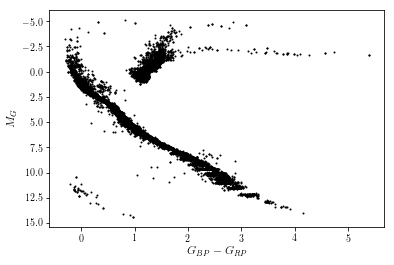

In [5]:
plt.scatter(data['(BP_RP)_0'],data['M_G'],s=1,c='k')
plt.gca().invert_yaxis()
plt.xlabel(r'$G_{BP}-G_{RP}$')
plt.ylabel(r'$M_G$') ;